In [1]:
#Import standard packages for model training

import tensorflow as T
from tensorflow import *
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
import numpy as np
import pandas as pd
import sklearn.metrics as SK
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import io

from utils.GPU import *
from utils import utils

commons = utils.Commons()
ts_helper = utils.TS_Helper()
ts_helper.model_type = ts_helper.Regression
shap_helper = utils.Shap_Helper() 
   
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

  tensorlayer: GPU MEM Fraction 0.900000
Num GPUs Available:  0


In [2]:
#Inport train, validation and test sets

training = './data/Regression/T.cruzi/random_split/train_fold_0.csv'
validation = './data/Regression/T.cruzi/random_split/valid_fold_0.csv'
test = './data/Regression/T.cruzi/random_split/test_fold_0.csv'
TASK_START = 2
NUM_TASKS = 1
SMILES = "SMILES"
train_dataset,y_train,train_smiles = commons.load_dataset(training,SMILES,TASK_START,NUM_TASKS)
val_dataset,y_val,val_smiles = commons.load_dataset(validation,SMILES,TASK_START,NUM_TASKS)
test_dataset,y_test,test_smiles = commons.load_dataset(test,SMILES,TASK_START,NUM_TASKS)
train_dataset.head()

Loaded dataset ./data/Regression/T.cruzi/random_split/train_fold_0.csv with shape: (1465, 3)
Loaded dataset ./data/Regression/T.cruzi/random_split/valid_fold_0.csv with shape: (184, 3)
Loaded dataset ./data/Regression/T.cruzi/random_split/test_fold_0.csv with shape: (183, 3)


,ID,SMILES,Tb_cruzi
0,1484,N1C2C=CC=CC=2C(CCOC2N=CC=NC=2C2C=CN=CC=2)=C1,6.850012
1,304,N(CCC1N=C(C2C=CC=C(F)C=2)SC=1)C(C(C)(C)C)=O,6.149354
2,650,N(S(C1SC(C2C=C(CN(CC3C=CN=CC=3)C)C=CC=2OC)=CC=...,6.299998
3,1096,C1C2OCOC=2C=C(C(CSC2N=C(C)C=C(C)C=2C#N)=O)C=1,5.700001
4,1482,OC(C1C=CC(OC(C)C)=C(F)C=1)(C1C=CC=C(C(N)=O)C=1...,7.004365


In [3]:
#Import atom and bond featurizers

from utils.graphs import *

#Gennerate graphs from SMILES

X_train = graphs_from_smiles(train_dataset.iloc[:,NUM_TASKS].values)

X_test = graphs_from_smiles(test_dataset.iloc[:,NUM_TASKS].values)

X_val = graphs_from_smiles(val_dataset.iloc[:,NUM_TASKS].values)

#Test graph function

# molecule = molecule_from_smiles(train_dataset.iloc[8].SMILES)
# molecules_graph = [molecule_from_smiles(smile) for smile in train_dataset.SMILES]
# graph = [graph_from_molecule(mol) for mol in molecules_graph]
# #graph = graph_from_molecule(molecule)
# print("Graph (including self-loops):")
# print("\tatom features\t", graph[0][0].shape)
# print("\tbond features\t", graph[0][1].shape)
# print("\tpair indices\t", graph[0][2].shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atom_features (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 bond_features (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 pair_indices (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 message_passing (MessagePassin  (None, 32)          14528       ['atom_features[0][0]',          
 g)                                                               'bond_features[0][0]',      

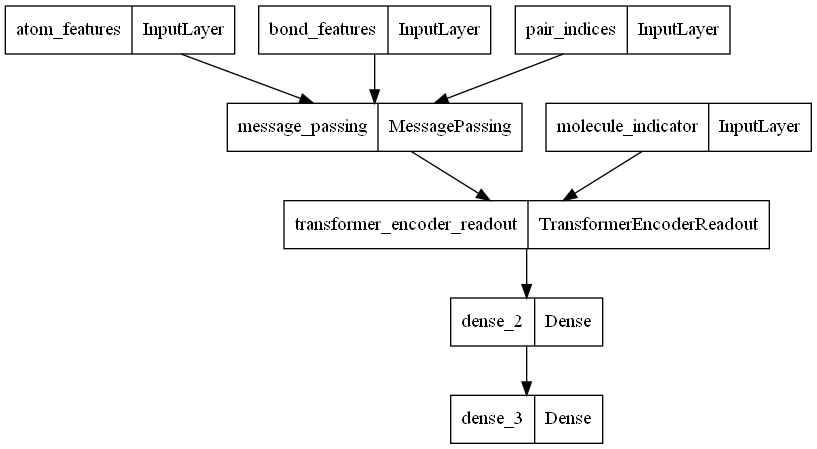

In [4]:
# Import parameters for batch, MPNN, loss and scorers

batch_size = 48
dense_units = 50

from utils.batch import *
from utils.MPNN import *
from utils.utils import *


# parameters for train network

def MPNNModel(atom_dim,
    bond_dim,
    batch_size=batch_size,
    message_units=32,
    message_steps=8,
    num_attention_heads=16,
    dense_units=dense_units):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)([atom_features, bond_features, pair_indices])
    x = TransformerEncoderReadout(num_attention_heads, message_units, dense_units, batch_size)([x, molecule_indicator])
    x = layers.Dense(50, activation="relu")(x)
    x = layers.Dense(NUM_TASKS, activation="linear")(x)
    
    model = keras.Model(inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x])
    return model
    


optimizer = RMSprop(0.1)
lr_metric = ts_helper.get_lr_metric(optimizer)   

model = MPNNModel(atom_dim = X_train[0][0][0].shape[0], bond_dim = X_train[1][0][0].shape[0])
model.compile(loss = ts_helper.regression_loss, metrics = [lr_metric])    
model.summary()
T.keras.utils.plot_model(model)

In [5]:
# Early stopping parameters

train_dataset = MPNNDataset(X_train, y_train, batch_size)
val_dataset = MPNNDataset(X_val, y_val, batch_size)
test_dataset = MPNNDataset(X_test, y_test, batch_size)

callbacks_list = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000001, verbose=1, mode='auto',cooldown=0),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', verbose=1)]

# parameters for train network

epochs=15

history = model.fit(train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_dataset,                    
                    callbacks=(callbacks_list))

model.save_weights("./models/TM-MPNN_regression_model.hdf5")

Epoch 1/15


c:\Users\Laplace\anaconda3\envs\AI\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/transformer_encoder_readout/partition_padding/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/transformer_encoder_readout/partition_padding/Reshape:0", shape=(None, None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model/transformer_encoder_readout/partition_padding/Cast:0", shape=(3,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\Laplace\anaconda3\envs\AI\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/message_passing/edge_network/Reshape_5:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/message_passing/edge_network/Reshape_4:0", shape=(None,

31/31 [==============================] - 11s 183ms/step - loss: 4.9563 - lr: 0.0010 - val_loss: 1.1913 - val_lr: 0.1000
Epoch 2/15
31/31 [==============================] - 5s 152ms/step - loss: 1.1708 - lr: 0.0010 - val_loss: 1.1886 - val_lr: 0.1000
Epoch 3/15
31/31 [==============================] - 5s 146ms/step - loss: 1.1640 - lr: 0.0010 - val_loss: 1.1747 - val_lr: 0.1000
Epoch 4/15
31/31 [==============================] - 4s 144ms/step - loss: 1.1074 - lr: 0.0010 - val_loss: 3.5261 - val_lr: 0.1000
Epoch 5/15
31/31 [==============================] - 4s 141ms/step - loss: 1.1455 - lr: 0.0010 - val_loss: 1.1187 - val_lr: 0.1000
Epoch 6/15
31/31 [==============================] - 4s 143ms/step - loss: 1.0392 - lr: 0.0010 - val_loss: 1.1081 - val_lr: 0.1000
Epoch 7/15
31/31 [==============================] - 5s 146ms/step - loss: 0.9835 - lr: 0.0010 - val_loss: 1.0535 - val_lr: 0.1000
Epoch 8/15
31/31 [==============================] - 5s 147ms/step - loss: 0.9247 - lr: 0.0010 - val_

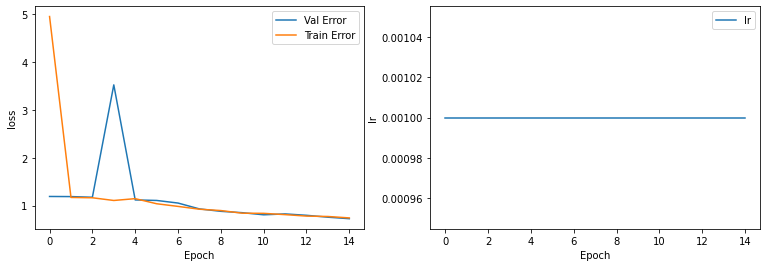

Metric for a Regression Model
31/31 [==============================] - 3s 66ms/step
Statistic       Value
-----------  --------
MSE          0.691629
MAE          0.656583
R2           0.381697


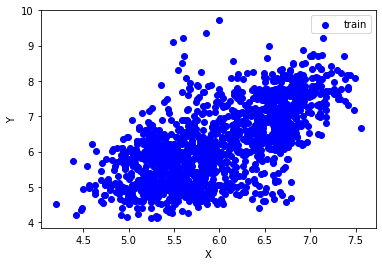

Metric for a Regression Model
4/4 [==============================] - 0s 64ms/step
Statistic       Value
-----------  --------
MSE          0.579492
MAE          0.603434
R2           0.492014


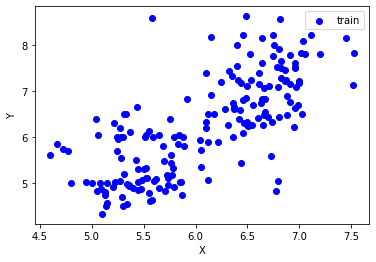

Metric for a Regression Model
4/4 [==============================] - 0s 62ms/step
Statistic       Value
-----------  --------
MSE          0.726288
MAE          0.68913
R2           0.379973


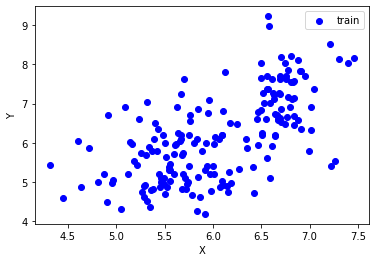

4/4 [==============================] - 0s 67ms/step


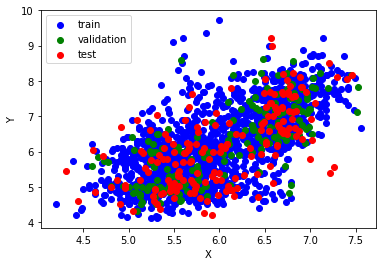

In [6]:
#Plot model history

ts_helper.plot_history(history)

ts_helper.get_modelStatsFor_Train_Test_Validation(model,train_dataset,y_train,test_dataset,y_test,val_dataset,y_val,NUM_TASKS)